<h2> Part 1 <h2/>

<h4> First question to answer and its motivation <h4/>
<li> Question: what kind of insurance package could the customer purchase, basic, extend or basic? 
<li> Motivation: 
As a insurance company locate and provide service in the USA, the most important question to be answer is, "what is the customers' risk preference and how much would he or she invest on the motor insurance?" , so when we construct the recommendation system we can allocate the most appropriate and optimal price to our potential customers and maximize the profit.





<h4>Possible Solution</h4>
<li>train classifier (random forest; SVM; etc)
<li>neural network

In [2]:
# package imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
import sklearn.metrics as metricss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# read data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
data = pd.read_csv('AutoInsurance.csv')
df = data.copy()
df.set_index('Customer', inplace= True) #the customer number is irelative with the classification so set it as index
df.head()

,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,,,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
df['Coverage'].value_counts()

Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64

In [4]:
#since we don't know about the when did the insurance started, so effective to date doesn't make much sense
df.drop(['Effective To Date'], axis = 1, inplace = True)

In [5]:
#functionalize the process of encoding the categorical variables
def encode(df):
    df['Coverage'] = df['Coverage'].map({'Premium': 3, 'Extended': 2, 'Basic': 1})

    data_type_dict = dict(df.dtypes)
    cat_list = [ele for ele in data_type_dict.keys() if data_type_dict[ele] == 'object']
    num_list = [ele for ele in data_type_dict.keys() if data_type_dict[ele] != 'object']
    if 'Coverage' in num_list:
        num_list.remove('Coverage')

    #encode/scale data    
    df = pd.get_dummies(df, columns = cat_list)
    
    return df, cat_list, num_list
    


In [6]:
df_transfered, cat_list, num_list = encode(df)
df_transfered


,Customer Lifetime Value,Coverage,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_Arizona,State_California,State_Nevada,State_Oregon,State_Washington,Response_No,Response_Yes,Education_Bachelor,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Disabled,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_F,Gender_M,Location Code_Rural,Location Code_Suburban,Location Code_Urban,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Policy Type_Corporate Auto,Policy Type_Personal Auto,Policy Type_Special Auto,Policy_Corporate L1,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Policy_Special L1,Policy_Special L2,Policy_Special L3,Renew Offer Type_Offer1,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Agent,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
Customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BU79786,2763.519279,1,56274,69,32,5,0,1,384.811147,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
QZ44356,6979.535903,2,0,94,13,42,0,8,1131.464935,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
AI49188,12887.431650,3,48767,108,18,38,0,2,566.472247,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
WW63253,7645.861827,1,0,106,18,65,0,7,529.881344,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
HB64268,2813.692575,1,43836,73,12,44,0,1,138.130879,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LA72316,23405.987980,1,71941,73,18,89,0,2,198.234764,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
PK87824,3096.511217,2,21604,79,14,28,0,1,379.200000,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
TD14365,8163.890428,2,0,85,9,37,3,2,790.784983,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


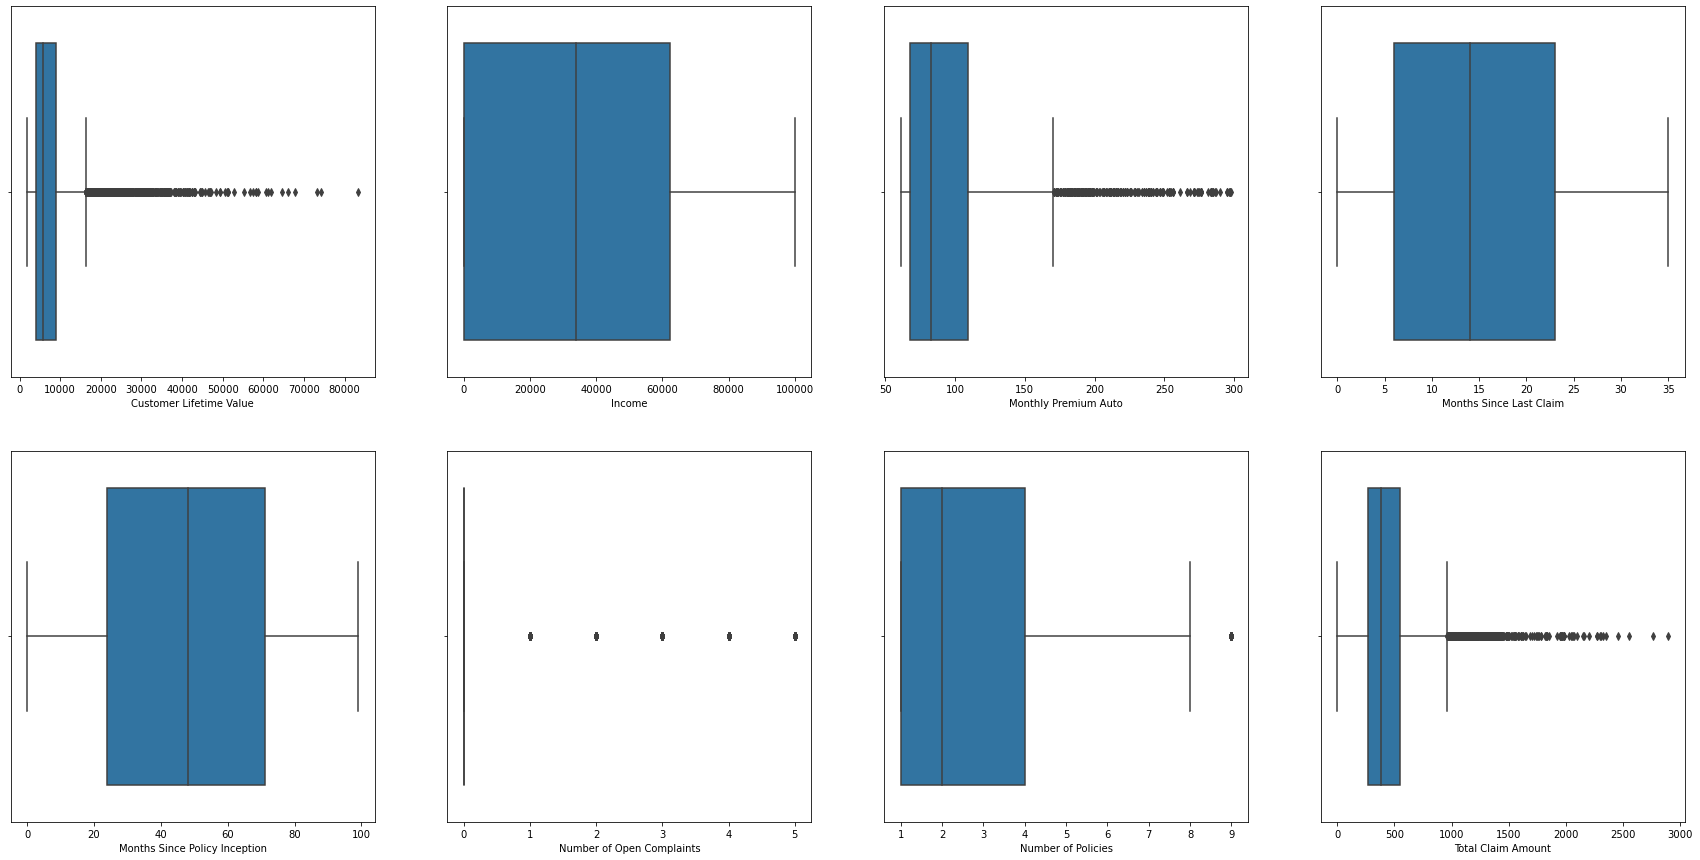

In [7]:
def check_outlier(df):
    col = num_list #all columns except the target value
    fig = plt.figure(figsize= (30, 15))
    for index, coln in enumerate(col):
        ax = fig.add_subplot(2, 4, index +1)
        ax = sns.boxplot(x=df[coln])

check_outlier(df_transfered)

In [8]:
#detect the outliers, check if the box plot really indicate the outlier
'''
As the output indicated, the "outliers" are not really outlier since they are occupying a unignorable percentage of all the values, so I would keep
them for a while.
'''
def outlier_detect(df, num_list, threshold = 1.5):
    for ele in num_list:
        lower_quantile = df[ele].quantile(0.25)
        upper_quantile = df[ele].quantile(0.75)
        upper_limit = upper_quantile + threshold*(upper_quantile - lower_quantile)
        print(ele)
        print("number of outliers: ", len(df.loc[df[ele] > upper_limit]))
        print("percentage of outliers: ",len(df.loc[df[ele] > upper_limit])/len(df))
        print('*********************************************')

outlier_detect(df_transfered, num_list)

Customer Lifetime Value
number of outliers:  817
percentage of outliers:  0.08944602583753011
*********************************************
Income
number of outliers:  0
percentage of outliers:  0.0
*********************************************
Monthly Premium Auto
number of outliers:  430
percentage of outliers:  0.047076855703963215
*********************************************
Months Since Last Claim
number of outliers:  0
percentage of outliers:  0.0
*********************************************
Months Since Policy Inception
number of outliers:  0
percentage of outliers:  0.0
*********************************************
Number of Open Complaints
number of outliers:  1882
percentage of outliers:  0.20604335449967157
*********************************************
Number of Policies
number of outliers:  416
percentage of outliers:  0.04554412086708999
*********************************************
Total Claim Amount
number of outliers:  453
percentage of outliers:  0.04959492007882636


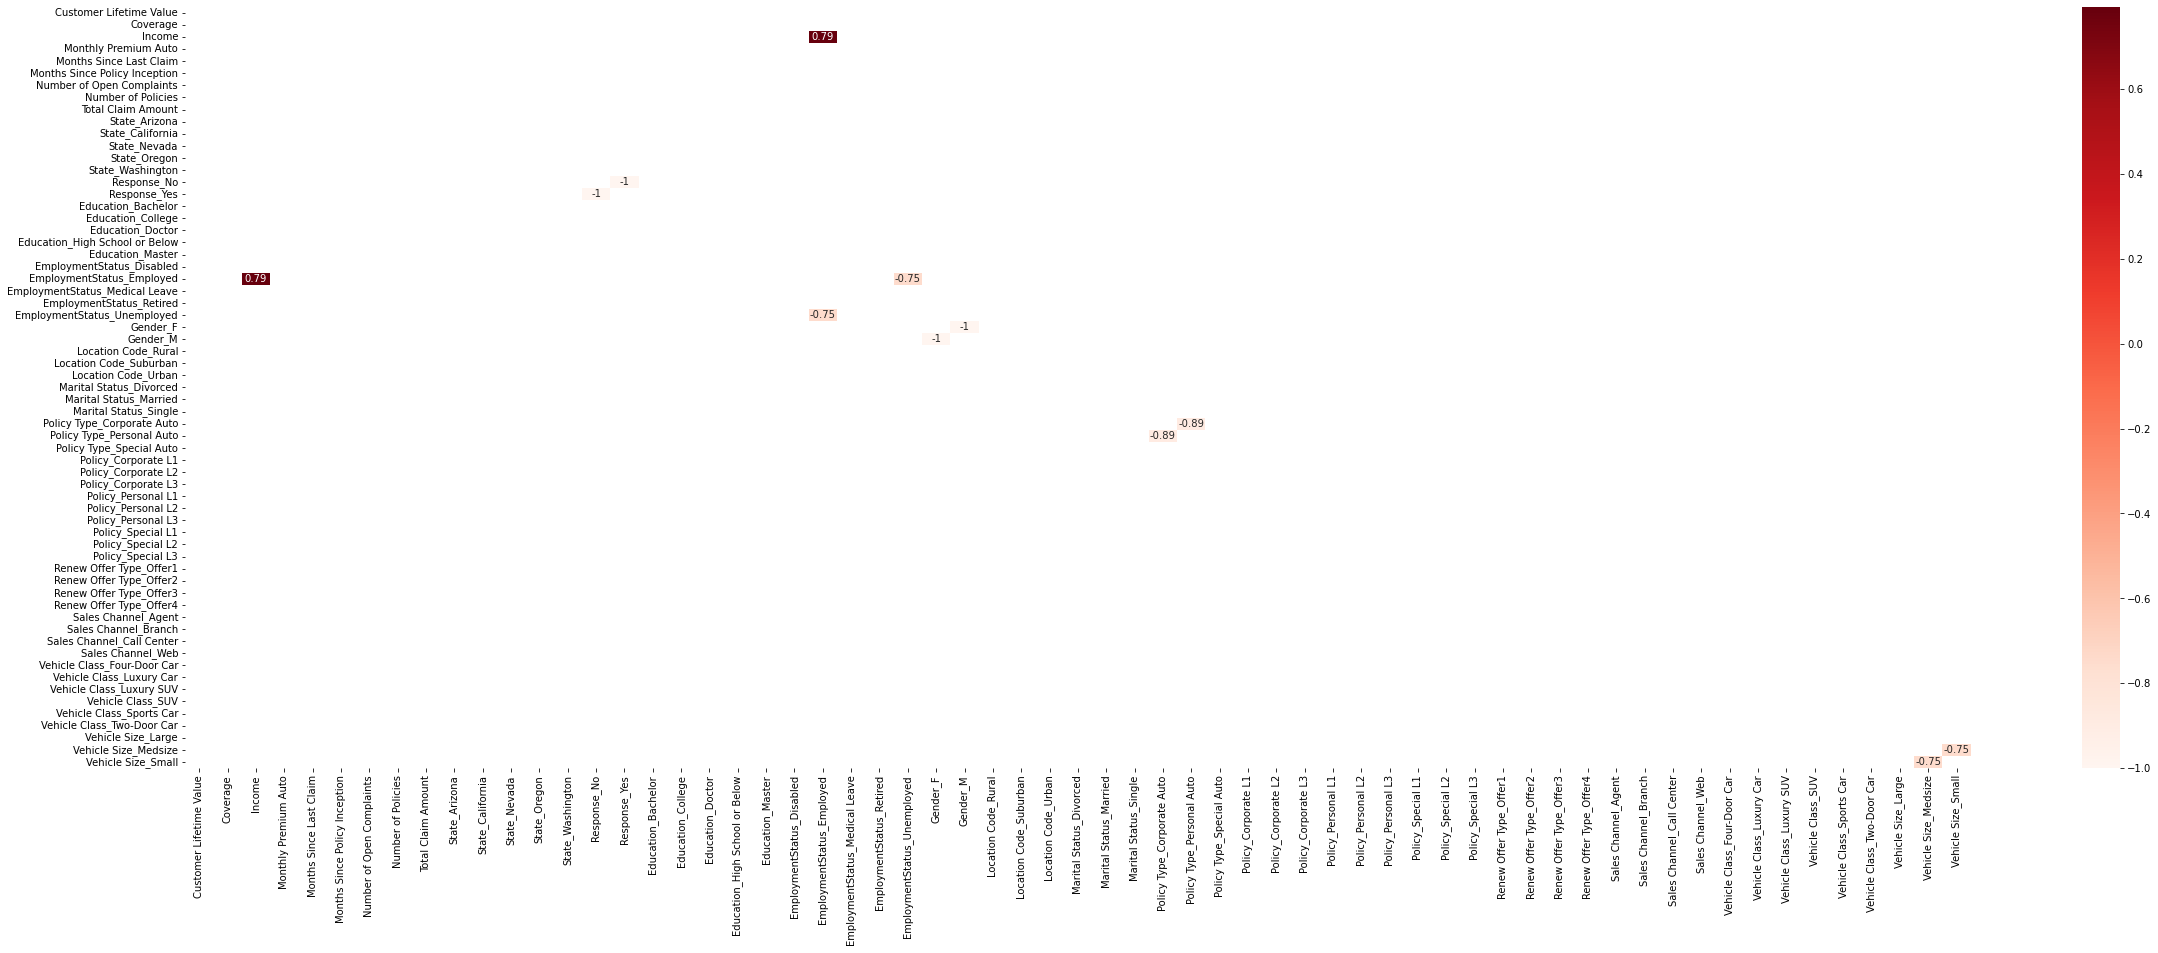

In [30]:
#check the correlation between features
def check_corr(df, bound = 0.75):
    #draw the correlation graph
    dfCorr = df.corr()
    filteredDf = dfCorr[((dfCorr >= bound) | (dfCorr <= -bound)) & (dfCorr !=1.000)]
    plt.figure(figsize=(40,14))
    sns.heatmap(filteredDf, annot=True, cmap="Reds")

    #list the high correlation pairs
    flattenDf = filteredDf.unstack().sort_values().drop_duplicates()

    
    return flattenDf, plt

flattenDf, plt = check_corr(df_transfered, bound = 0.75)
plt.show()

In [27]:
flattenDf

Gender_F                    Gender_M                      -1.000000
Response_No                 Response_Yes                  -1.000000
Policy Type_Corporate Auto  Policy Type_Personal Auto     -0.891417
Vehicle Size_Medsize        Vehicle Size_Small            -0.753241
EmploymentStatus_Employed   EmploymentStatus_Unemployed   -0.750760
Income                      EmploymentStatus_Employed      0.793875
Customer Lifetime Value     Customer Lifetime Value             NaN
dtype: float64

In [29]:
plt.show()